In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import Constants as C
from PlotTool import PlotTool
from Loader import Loader
from Cuts import qlayerCut, qratio

import matplotlib.pyplot as plt

savedir = '../plots/cutsana/'

In [2]:
# Define some selection
basesel = '(NPE>1000 && hs_q_tot_pulses>1000 && !passHESE && hm_nhit_doms > 50)'

# Load the data here
loader = Loader(basesel)

dt_data = loader.getData()
dt_cor  = loader.getCorsika()
dt_nue  = loader.getNuE()
dt_numu = loader.getNuMu()

In [3]:
# insert the qratio into the frame
def addqratio(data):
    data['qratio'] = pd.Series( qratio(data), index=data.index)
    return data

dt_data = addqratio(dt_data)
dt_cor  = addqratio(dt_cor)
dt_nue  = addqratio(dt_nue)
dt_numu = addqratio(dt_numu)

In [4]:
# OK! Now check outer-hit agreement
strings = [1,2,3,4,5,6,
           13,21,30,40,50,
           59,67,74,
           73,72,
           78,77,76,75,
           68,60,51,41,31,
           22,14,7]
def addfirsthit(data):
    data['firsthitout'] = pd.Series( data['StrNearly5[0]'].apply(lambda x: x in strings),
                                    index = data.index)
    return data
    
dt_data = addfirsthit(dt_data)
dt_nue  = addfirsthit(dt_nue)
dt_numu = addfirsthit(dt_numu)
dt_cor  = addfirsthit(dt_cor)


In [5]:
# Now that the data is loaded, put everything into an info object
dt_mc = pd.concat([dt_cor, dt_nue, dt_numu])

def getinfo(data, mctot, cor, nue, numu):

    return {'data' : [data, mctot, cor, nue, numu, nue, numu],
            'names'    : ['Data',
                          'Total Bkg.', 
                          r'Atmos. $\mu$',
                          r'Atmos. $\nu_{e}$', 
                          r'Atmos. $\nu_{\mu}$',
                          r'Astro. $\nu_{e}$',
                          r'Astro. $\nu_{\mu}$'],
            'weights' : ['w','w','w','w','w', 'wE2', 'wE2'], 
            'colors'  : ['black', 'r', 'm', 'g', 'b', 'y','c'],
            'lw'      : [0, 1.5, 1.5, 1.5, 1.5,1.5,1.5],
            'ls'      : ['solid','dashed','solid','solid','solid','solid','solid'],
            'marker'  : ['.',' ', ' ', ' ', ' ',' ',' ']
    }
    
info = getinfo(dt_data, dt_mc, dt_cor, dt_nue, dt_numu)

In [6]:
# Initialize the plot tool
p_tool = PlotTool()

# Now drop in some stacked plots that we want to understand
variables = {'hs_z_travel' : [25,-500,500, 'ztravel','z-travel [m]'],
             'rho_travel'  : [25, 0, 1000, 'rhotravel', r'$\rho$-travel [m]'],
             'log10(hs_q_tot_pulses)' : [40, 3, 7, 'logqtot','log10(NPE)'],
             'log10(NPE)'     : [40, 3, 7, 'lognpe','log10(NPE) (portia)'],
             #'cos(ImpLF_zen)' : [30, -1, 1, 'coszen', r'cos($\theta$)'],
             'qratio'         : [100,0,1,'qratio','qratio'],
             'hm_nhit_doms'   : [50,0,1500, 'hitdoms', r'N Hit Doms'],
             'Nch'            : [20,0,1500, 'Nch', 'N Channel (portia)'],
             'firsthitout'    : [2,-0.5,1.5, 'firsthitout', 'First Hit Outer'],
             'tlarge5[0]-tearly5[0]'  : [100, 0, 10000, 'tEarlyMinusLarge', 'tlarge-tearly'],
             'risetimelarge5cumu[0]'  : [40, 0, 400, 'risetime0Cumu','Risetime0 (Cumulative) [ns]'],
             'risetimelarge5[0]'  : [40, 0, 400, 'risetime0','Risetime0 [ns]'],
             'risetimelarge5cumu[1]'  : [40, 0, 400, 'risetime1Cumu','Risetime1 (Cumulative) [ns]'],
             'risetimelarge5[1]'  : [40, 0, 400, 'risetime1','Risetime1 [ns]'],
             'widthlarge5[0]' : [40,0,400,'width0','Width0 [ns]'],
             'widthlarge5[1]' : [40,0,400,'width1','Width1 [ns]'],
            }



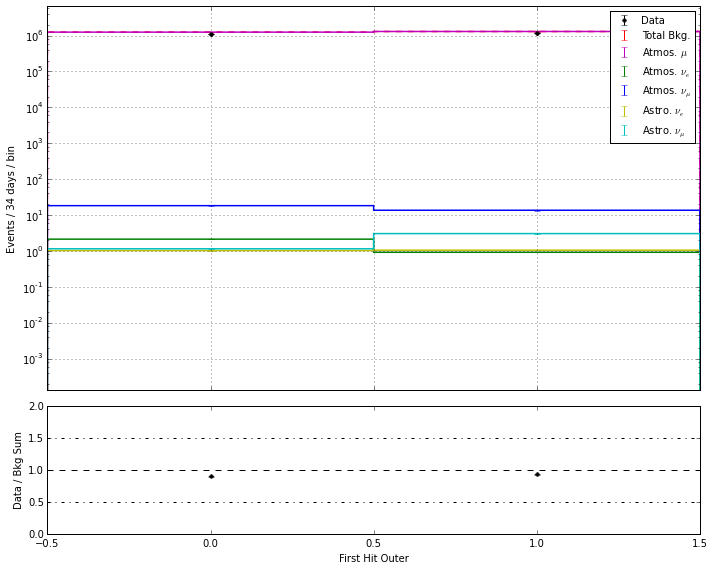

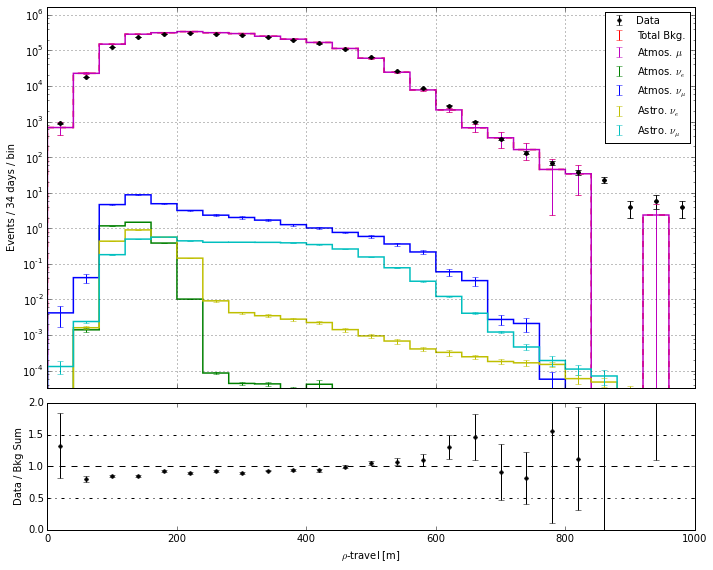

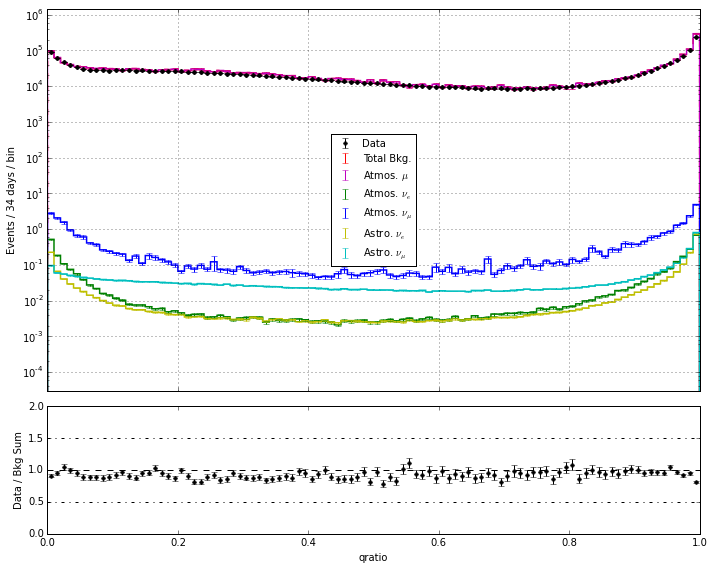

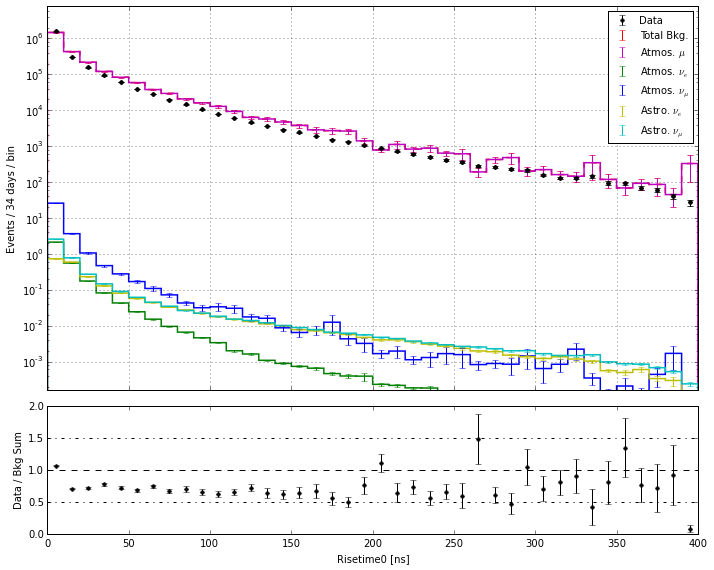

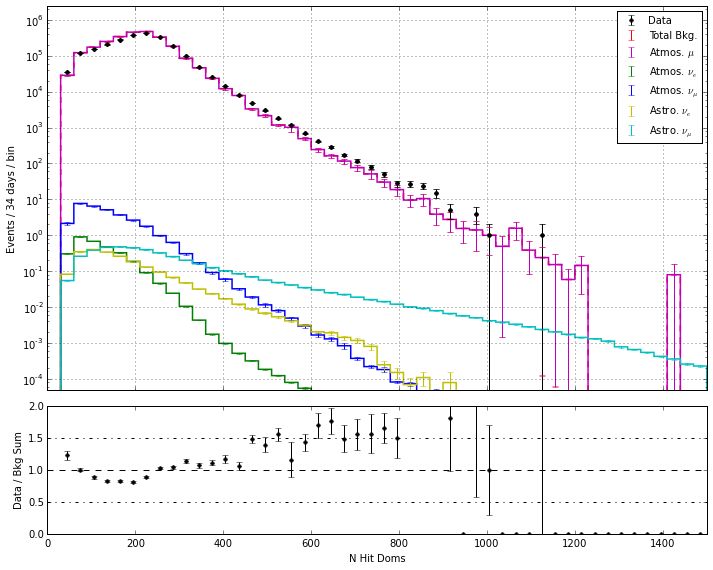

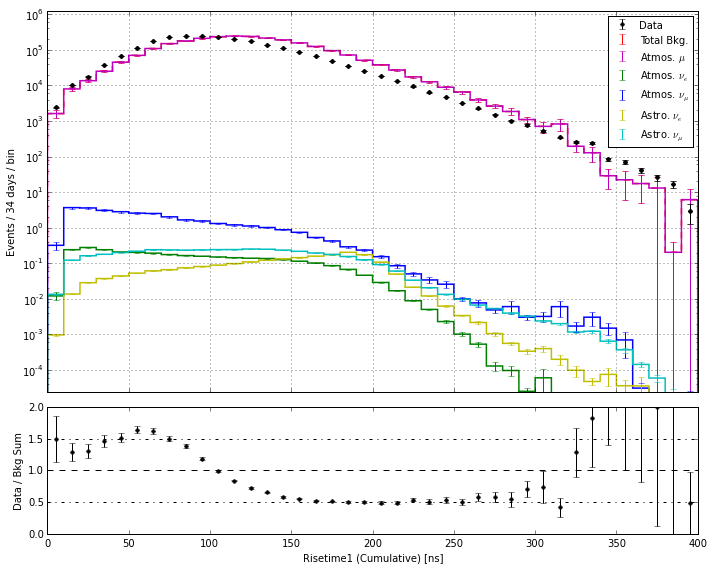

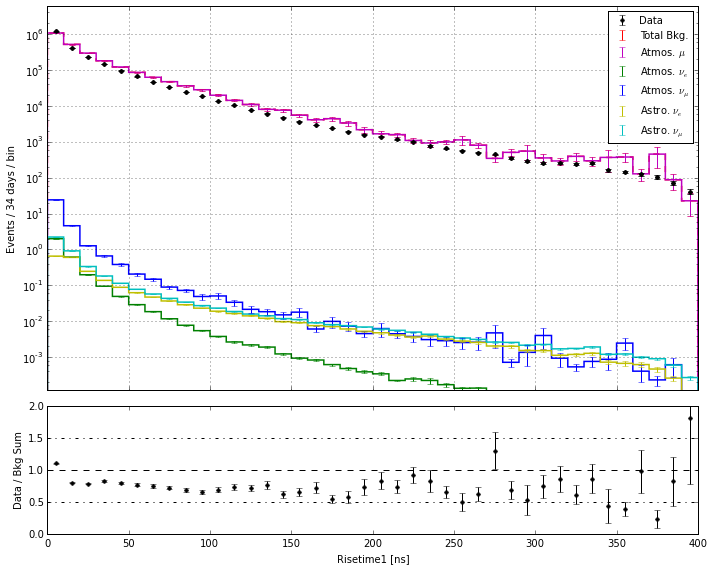

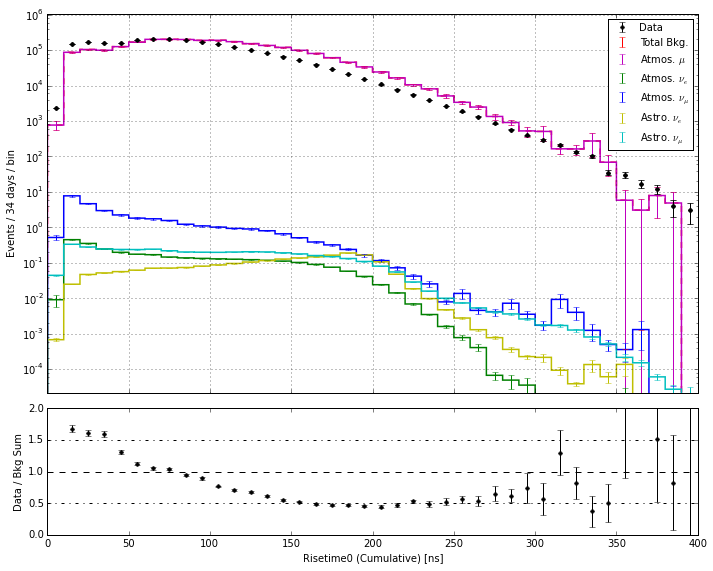

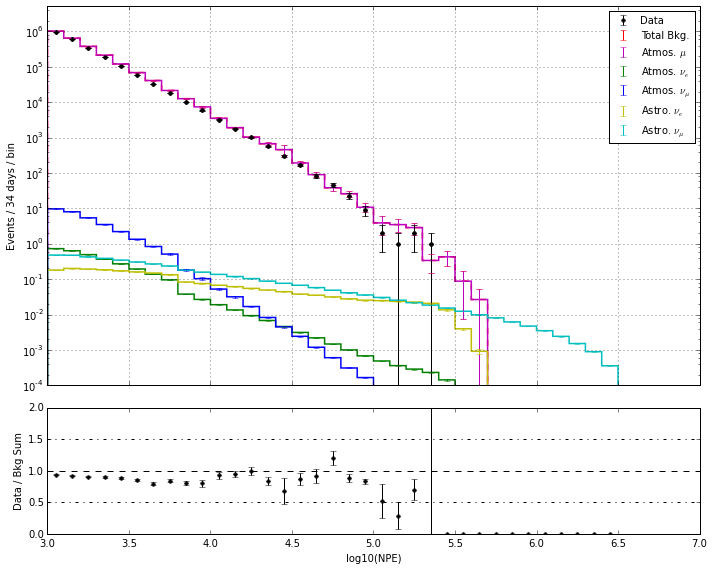

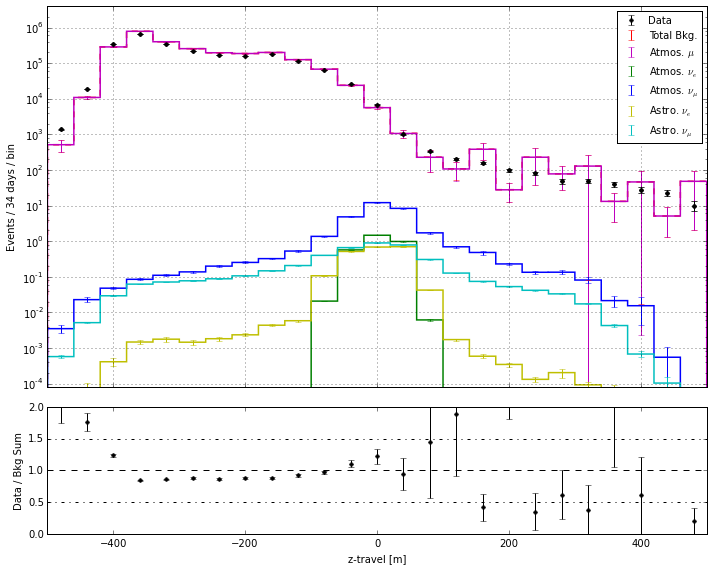

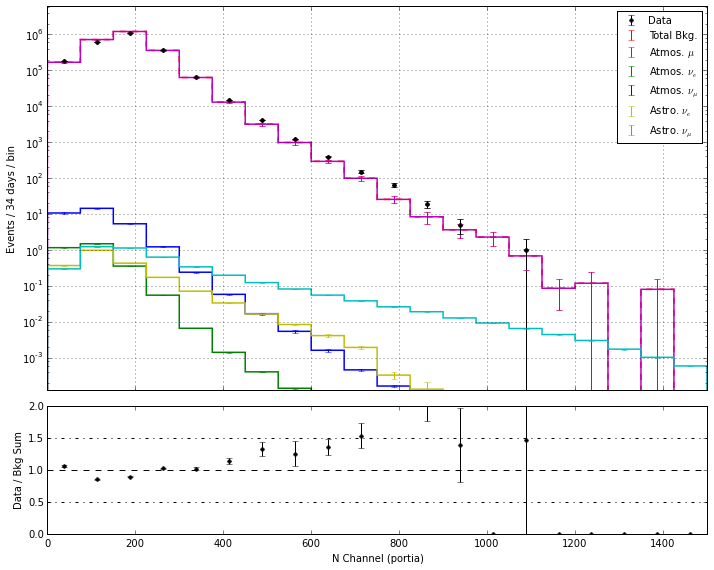

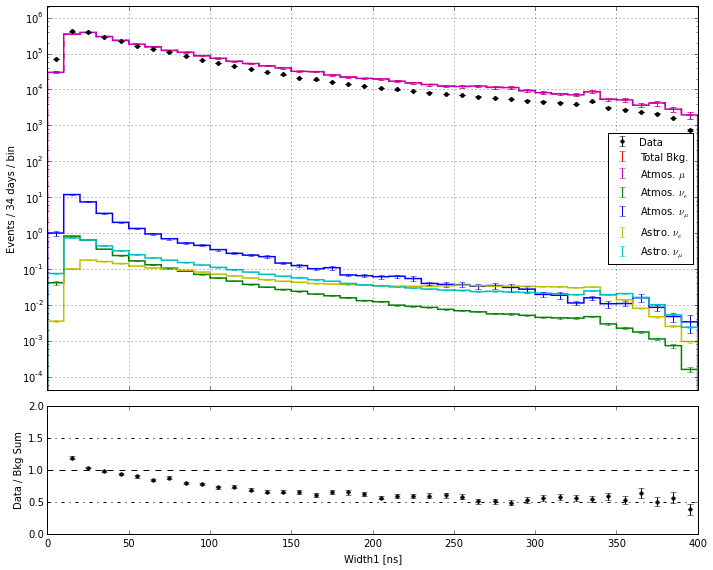

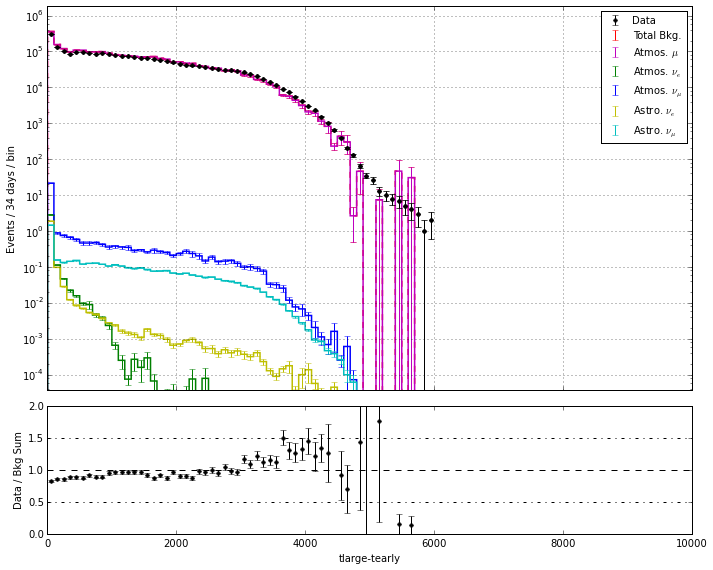

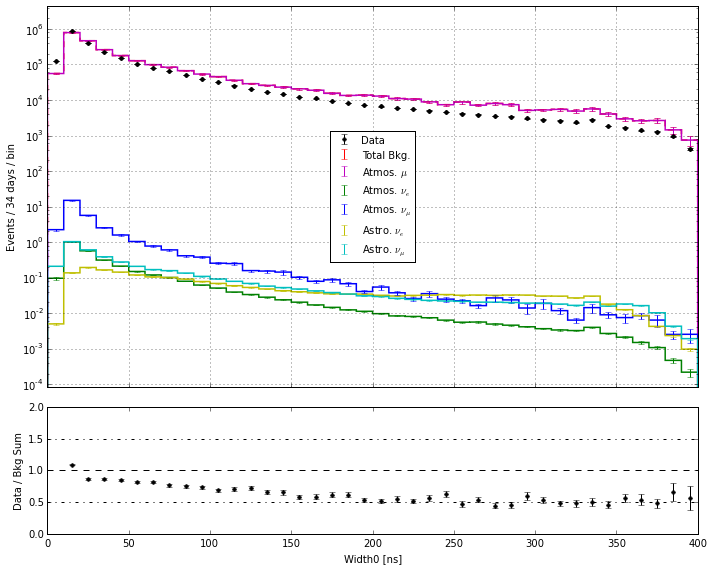

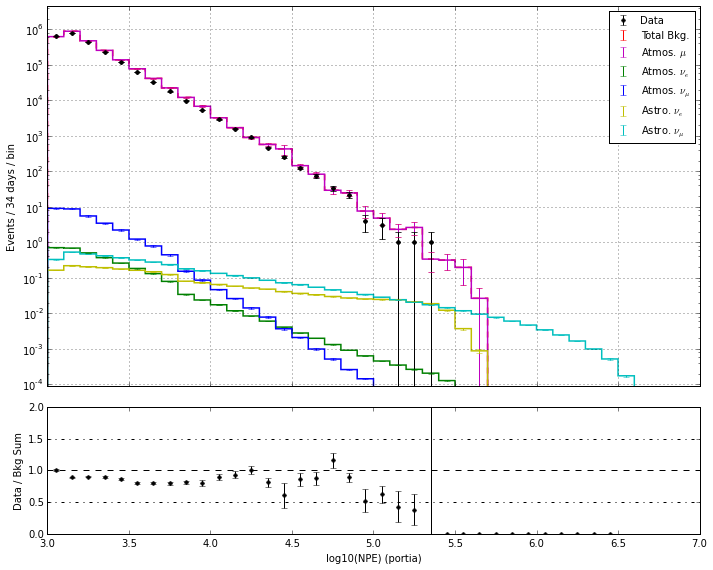

In [7]:
for var in variables:
    
    lims = variables[var]
    
    p_tool.plotStackedRatio(info, 
                            var, 
                            lims[4],
                            lims[0], lims[1], lims[2], 
                            1e-10,
                            True, False)
    
    plt.savefig(savedir+'baseline/'+lims[3]+'.png')

In [8]:
# It's clear we cannot use these as is, but perhaps we are just in
# difficult areas to model (eg. low Ndom).  Let's focus on our outer 
# events

# Apply qlayerCut
dt_data = qlayerCut(dt_data, False, 0.8)
dt_numu = qlayerCut(dt_numu, False, 0.8)
dt_nue  = qlayerCut(dt_nue, False, 0.8)
dt_cor  = qlayerCut(dt_cor, False, 0.8)
dt_mc   = qlayerCut(dt_mc, False, 0.8)

info = getinfo(dt_data, dt_mc, dt_cor, dt_nue, dt_numu)


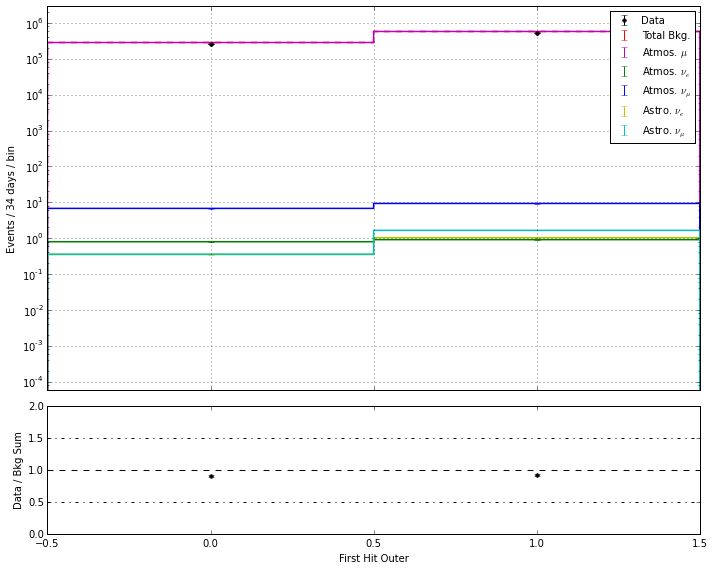

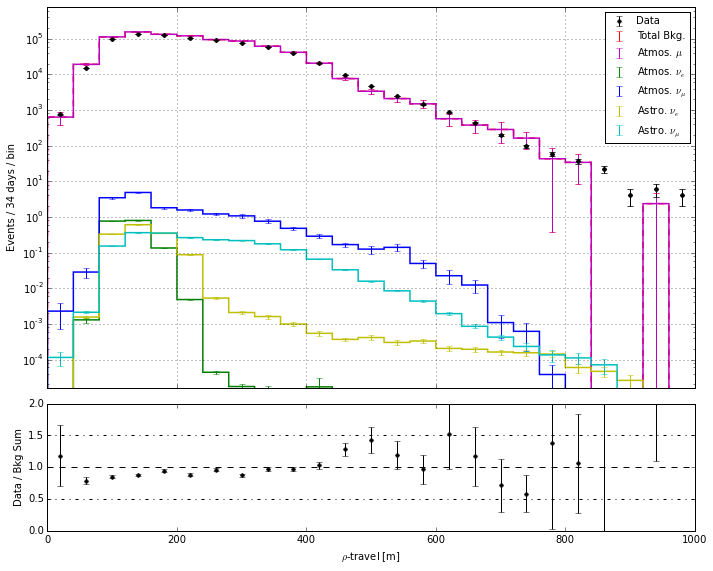

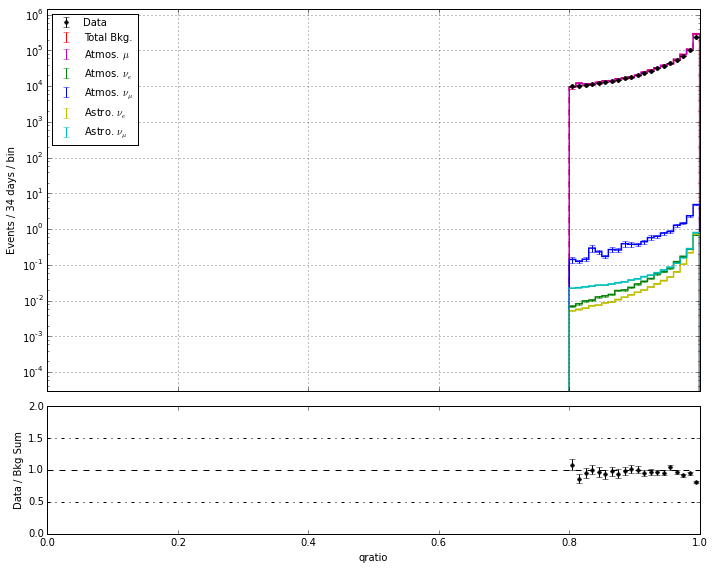

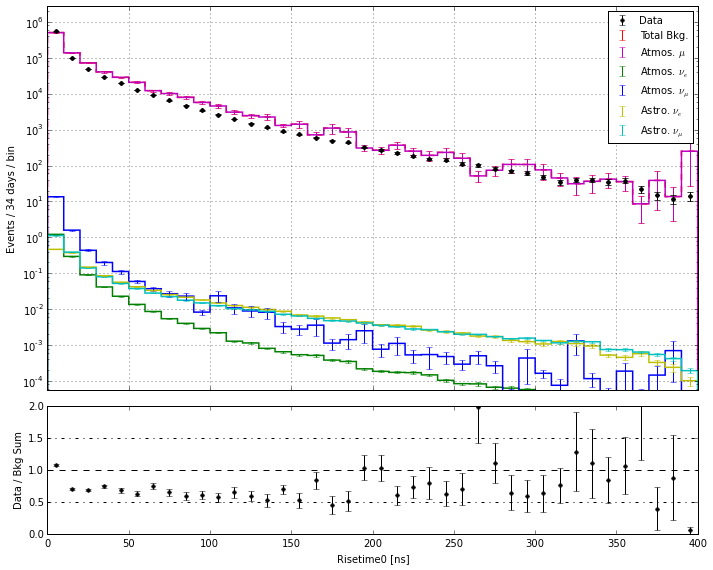

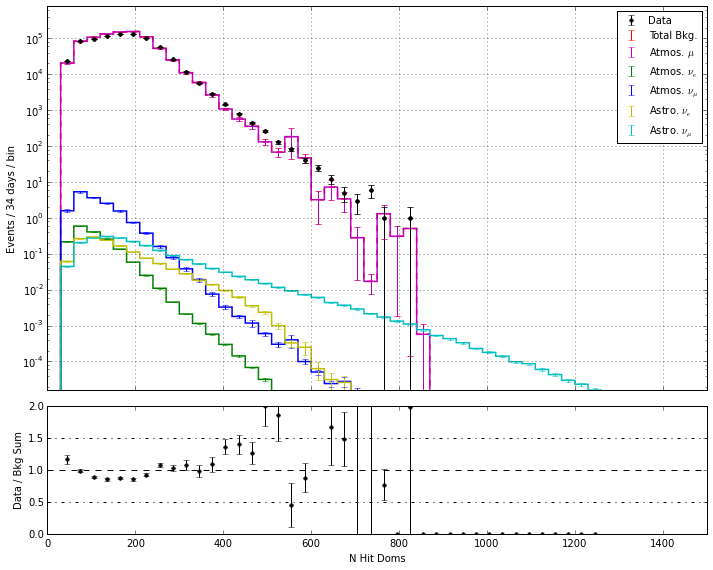

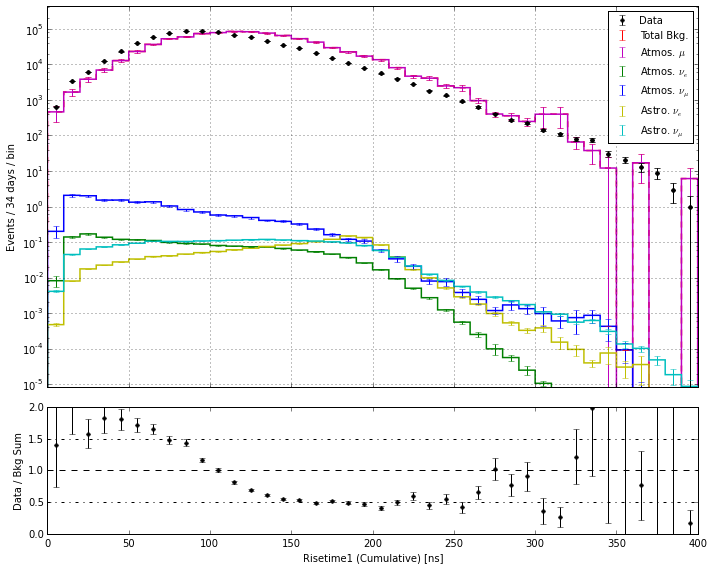

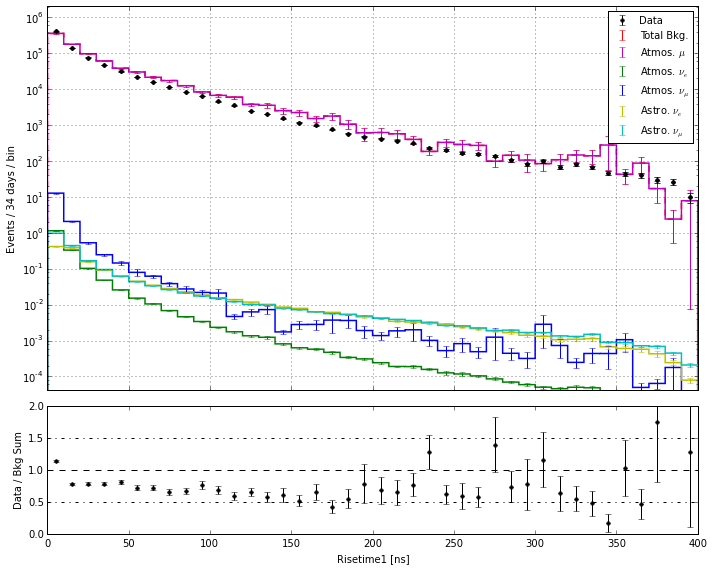

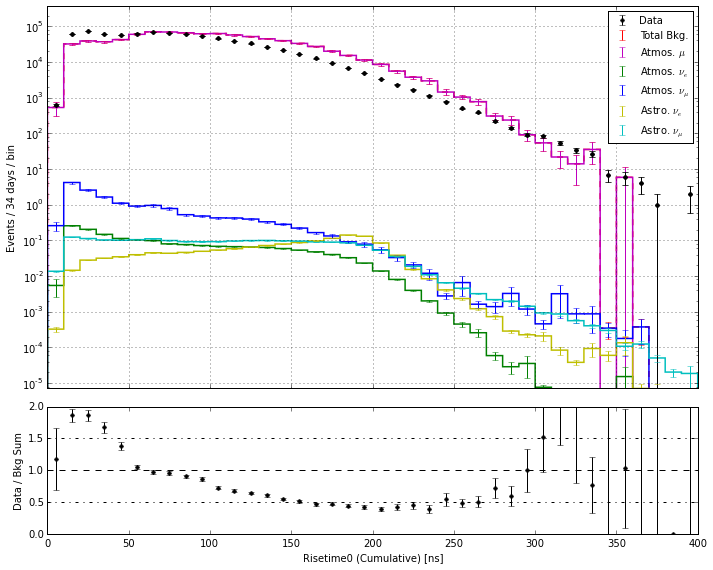

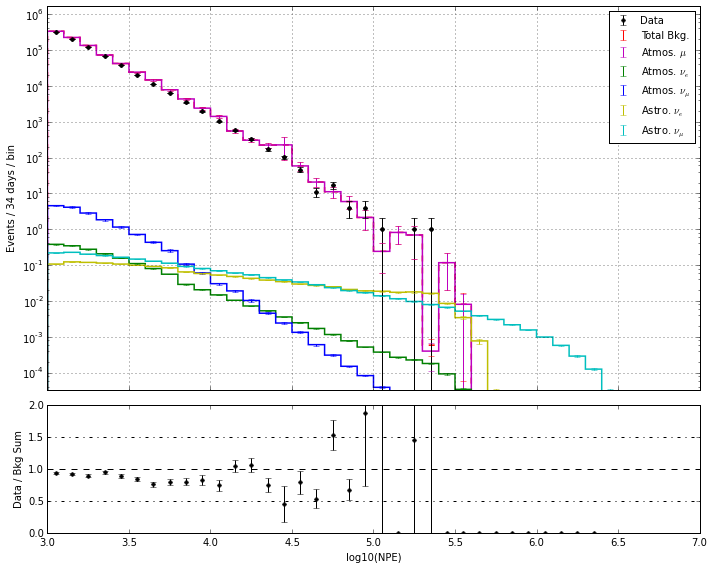

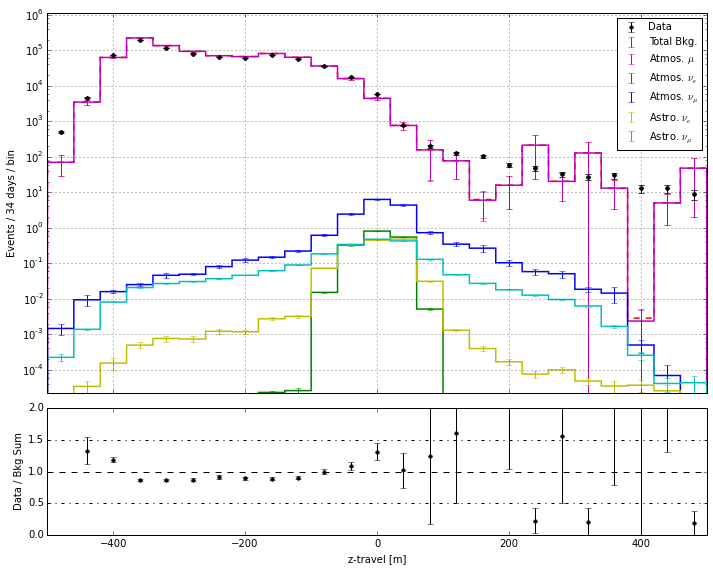

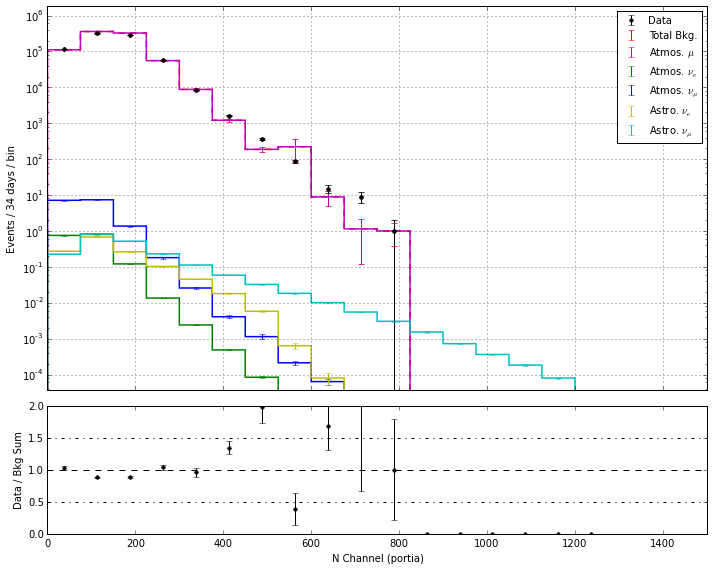

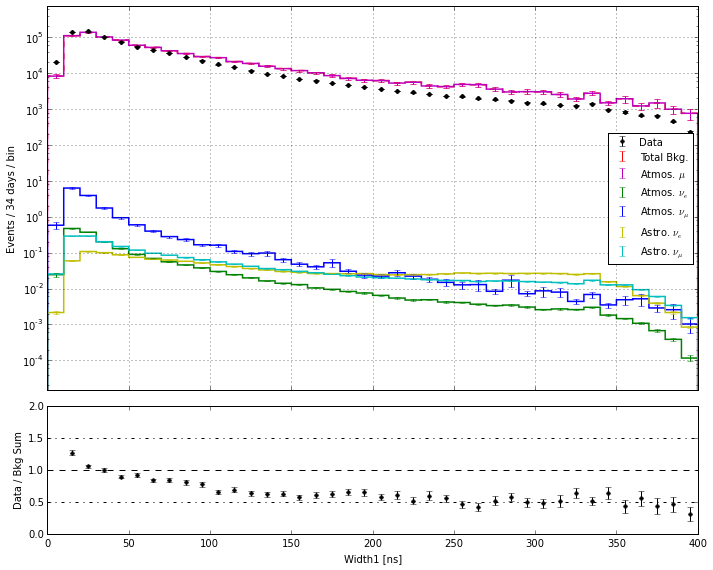

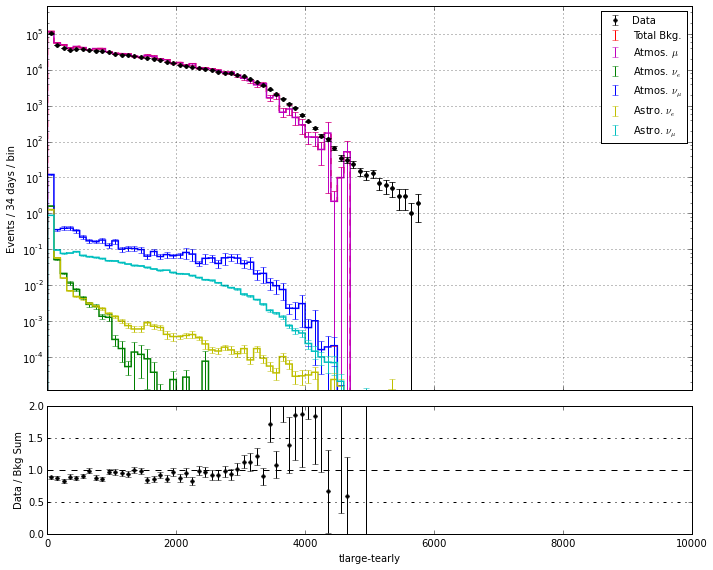

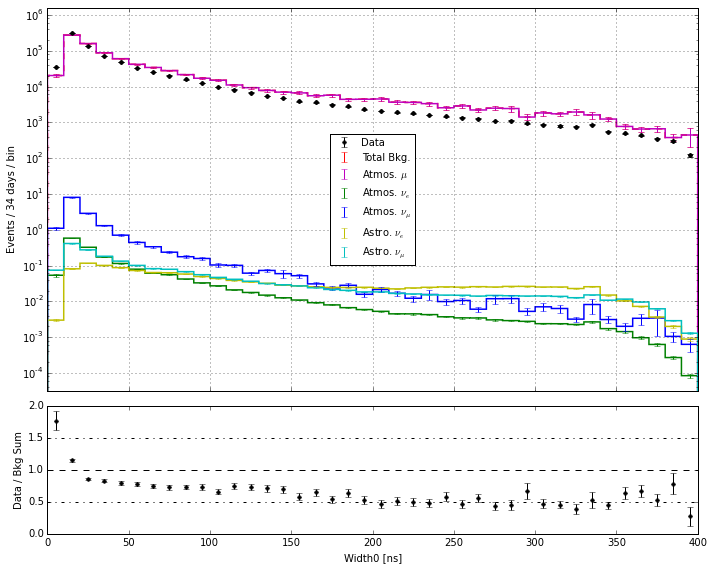

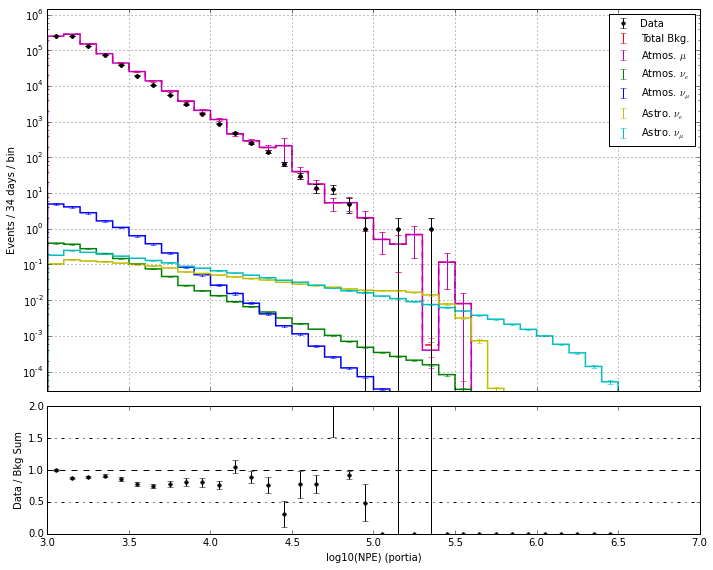

In [9]:
# Check variables again after the cut
for var in variables:
    
    lims = variables[var]
    
    p_tool.plotStackedRatio(info, 
                            var, 
                            lims[4],
                            lims[0], lims[1], lims[2], 
                            1e-10,
                            True, False)

    plt.savefig(savedir+'qratiocut/'+lims[3]+'.png')

In [10]:
# Cut on firsthitout -- require the first hit to be outside the detector
# This should maybe be moved up!  Or we can tighten the qratio cut a
# little more for these events?

def outercut(dt):
    return dt[ dt['firsthitout'] > 0.5]

dt_data = outercut(dt_data)
dt_numu = outercut(dt_numu)
dt_nue  = outercut(dt_nue)
dt_cor  = outercut(dt_cor)
dt_mc   = outercut(dt_mc)

info = getinfo(dt_data, dt_mc, dt_cor, dt_nue, dt_numu)

#for i in range(len(info['data'])):
#    info['data'][i] = info['data'][i][ info['data'][i]['firsthitout'] > 0 ]

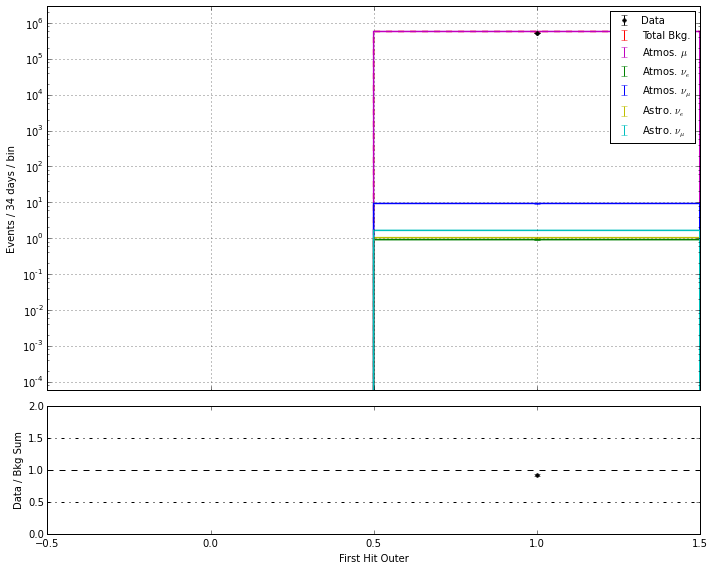

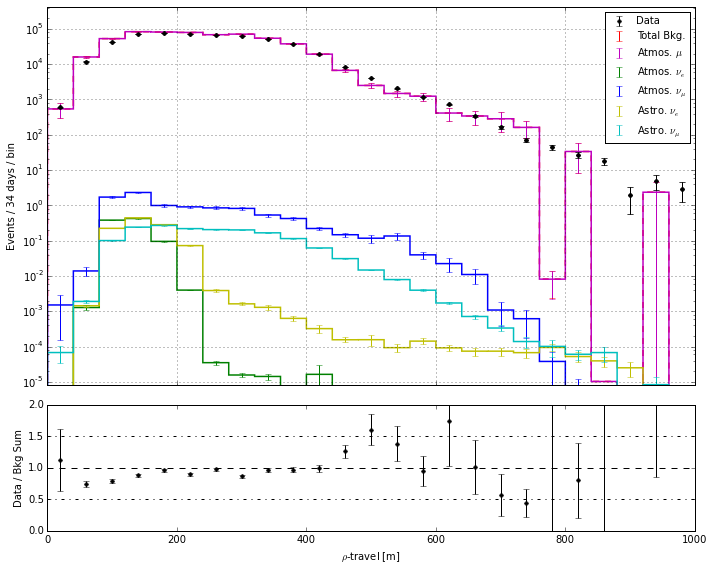

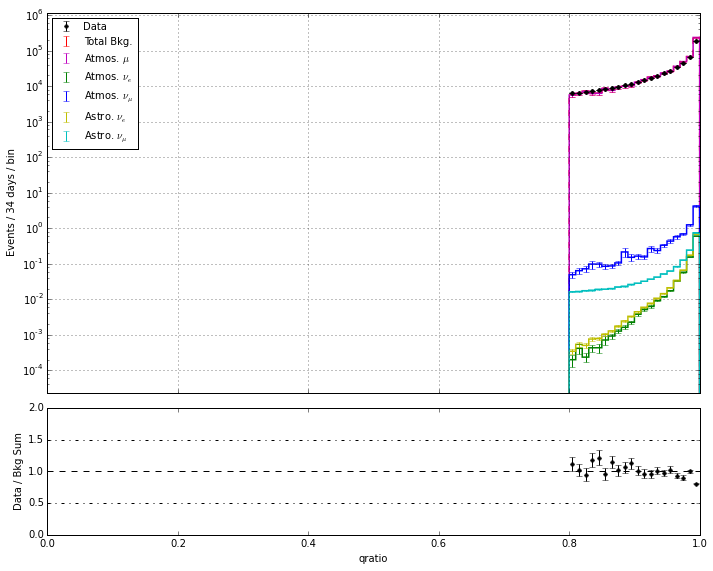

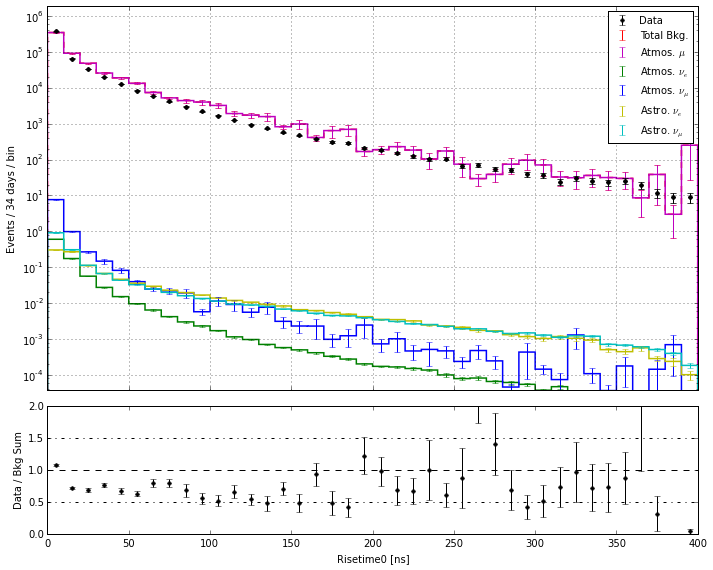

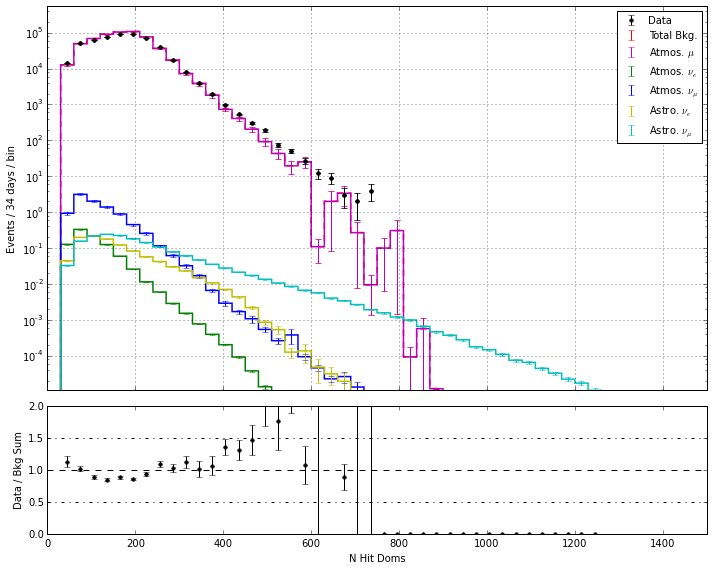

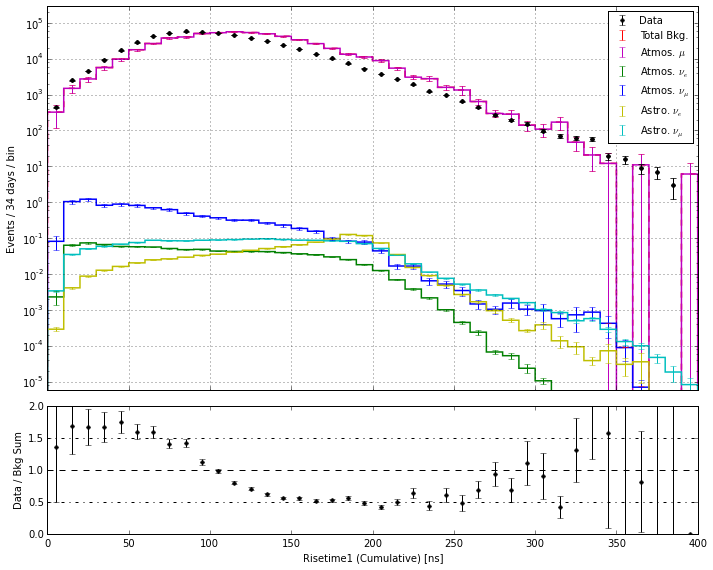

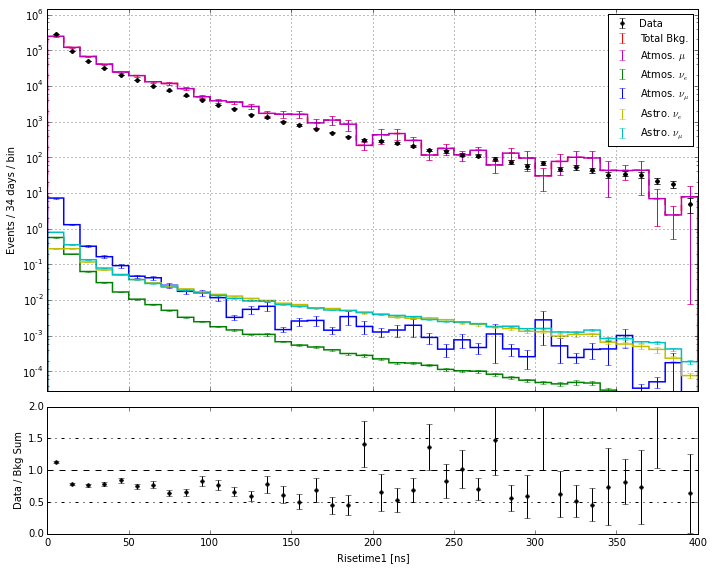

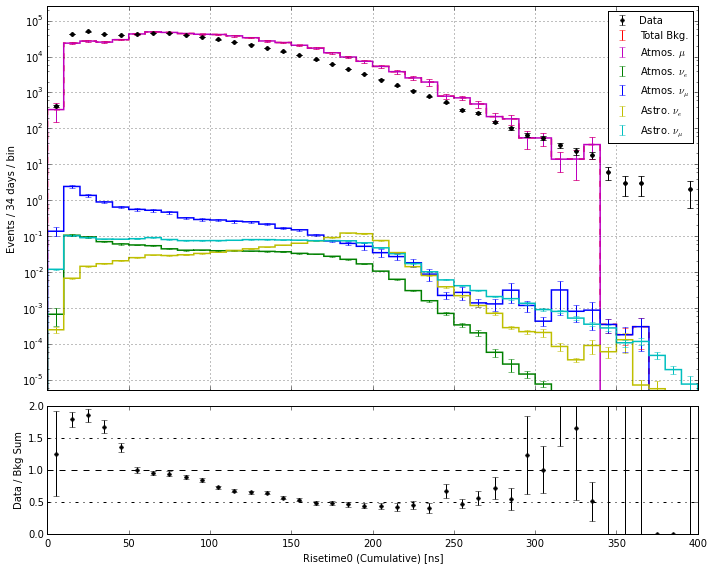

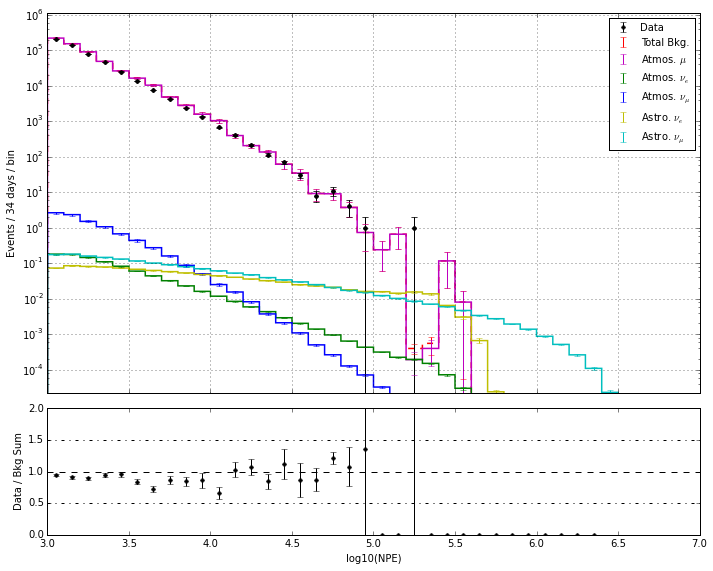

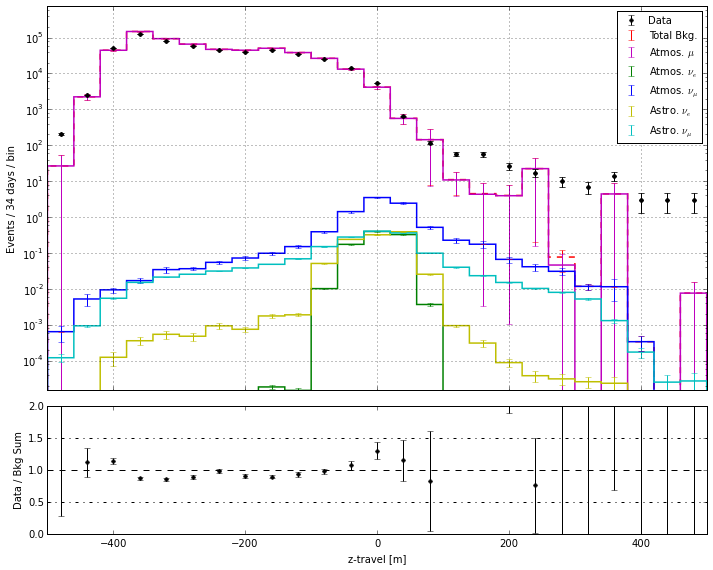

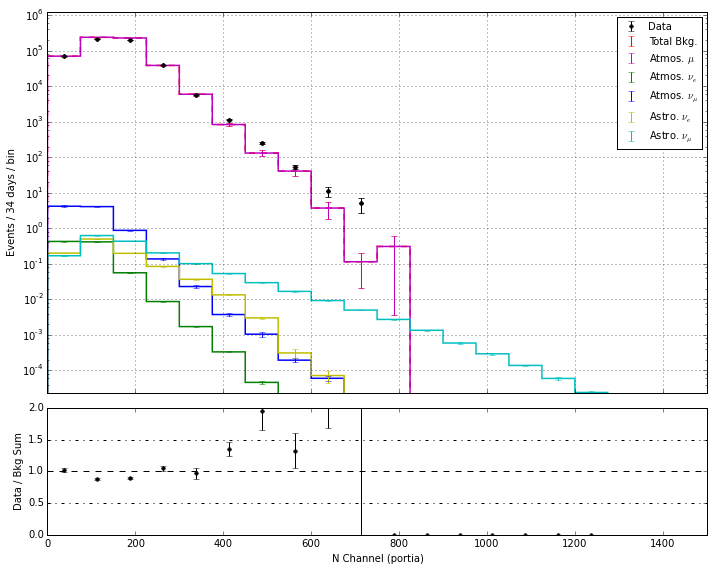

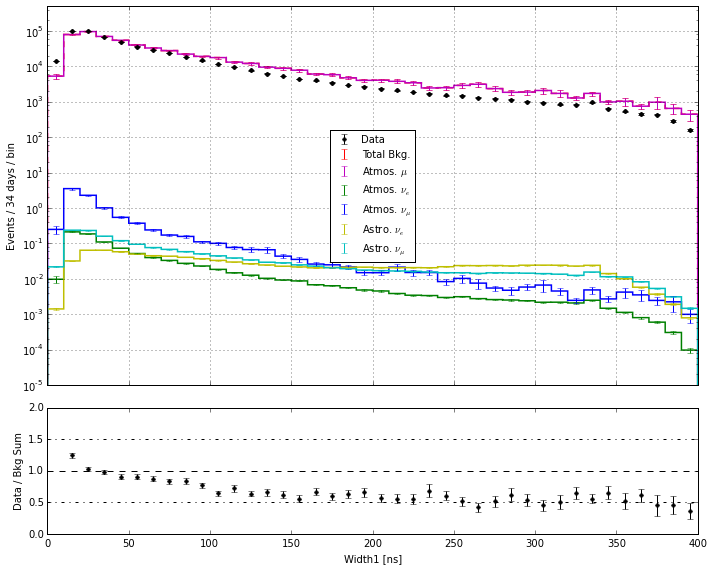

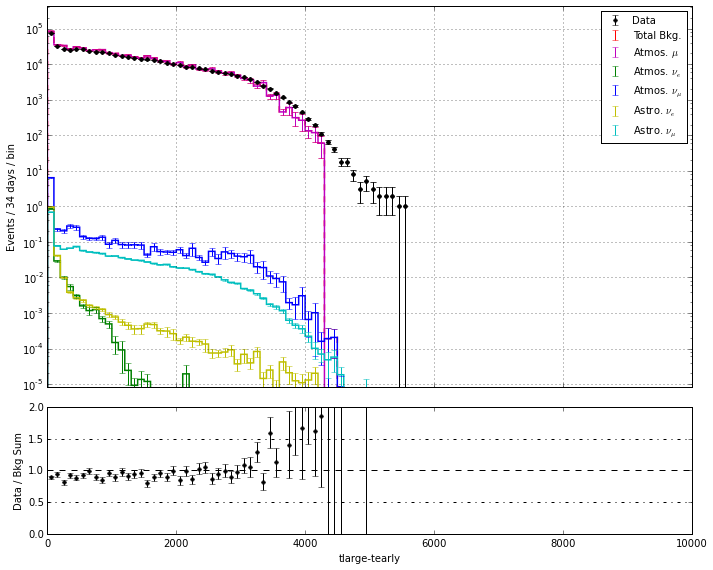

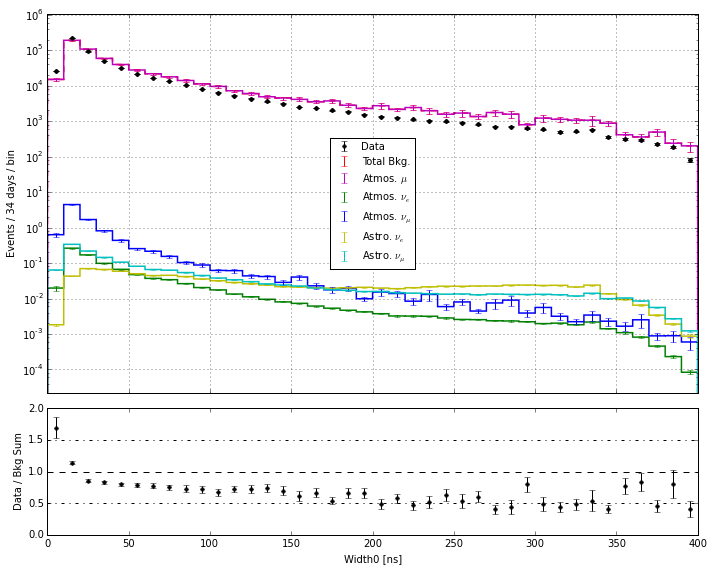

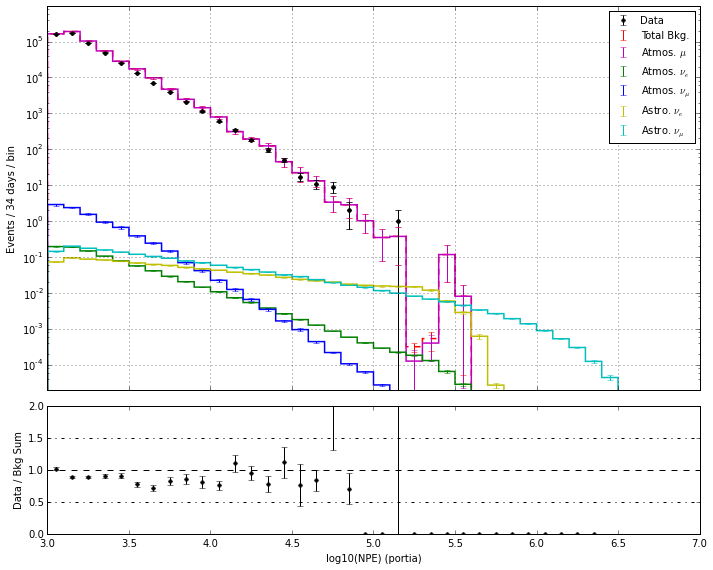

In [11]:
for var in variables:
    
    lims = variables[var]
    
    p_tool.plotStackedRatio(info, 
                            var, 
                            lims[4],
                            lims[0], lims[1], lims[2], 
                            1e-10,
                            True, False)
    
    plt.savefig(savedir+'qratiocut_outerhit/'+lims[3]+'.png')

In [12]:
# Now cut on rho-travel
def rhotravelcut(data, cval):
    return data[ data['rho_travel'] < cval]

dt_data = rhotravelcut(dt_data, 250)
dt_numu = rhotravelcut(dt_numu, 250)
dt_nue  = rhotravelcut(dt_nue, 250)
dt_cor  = rhotravelcut(dt_cor, 250)
dt_mc   = rhotravelcut(dt_mc, 250)

info = getinfo(dt_data, dt_mc, dt_cor, dt_nue, dt_numu)

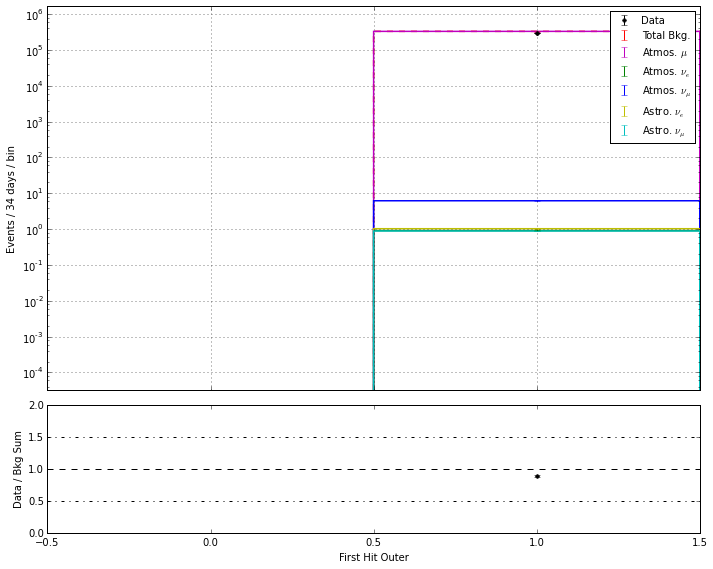

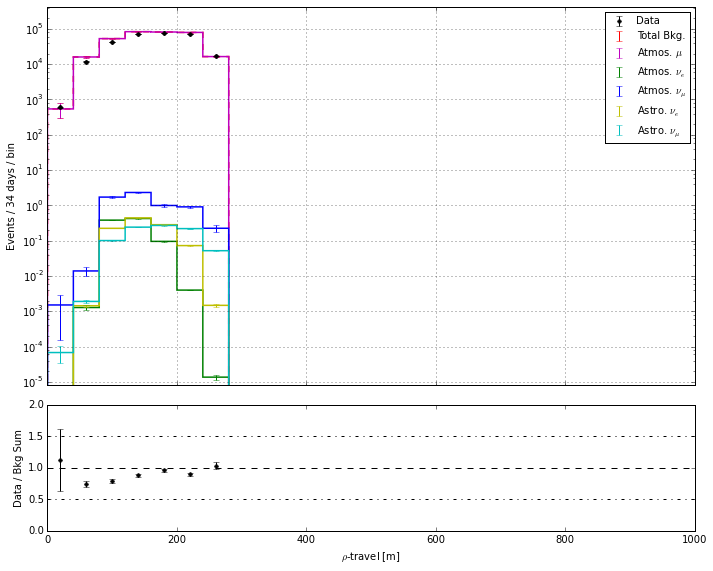

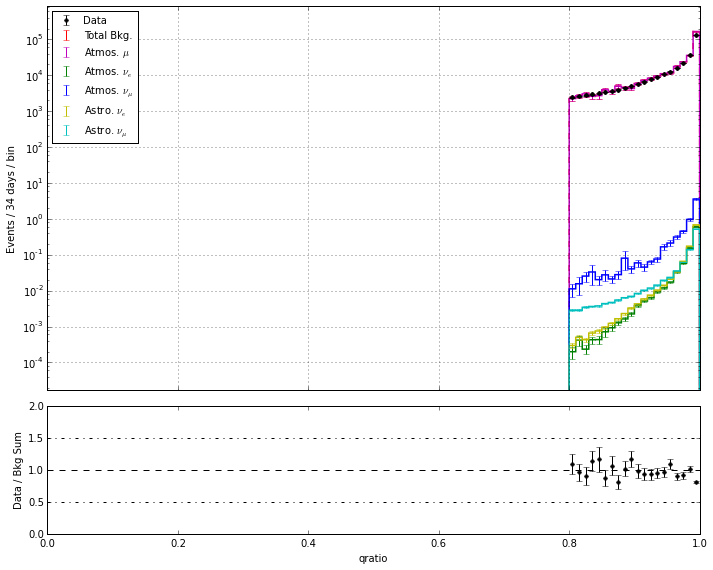

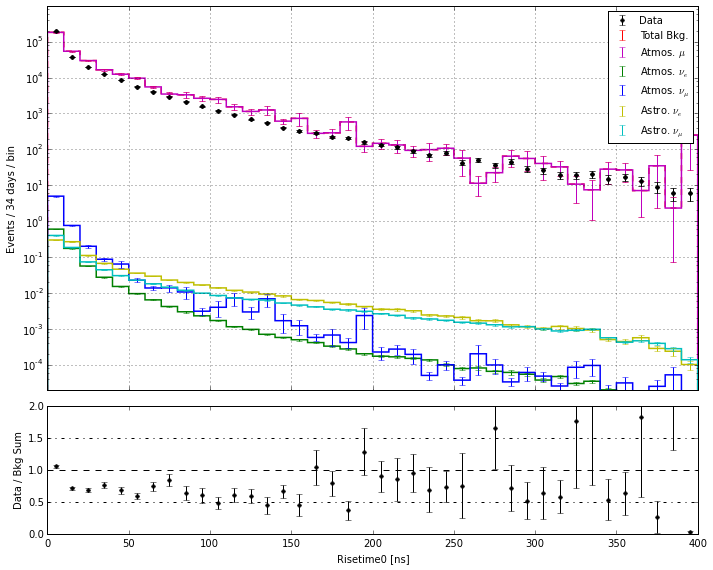

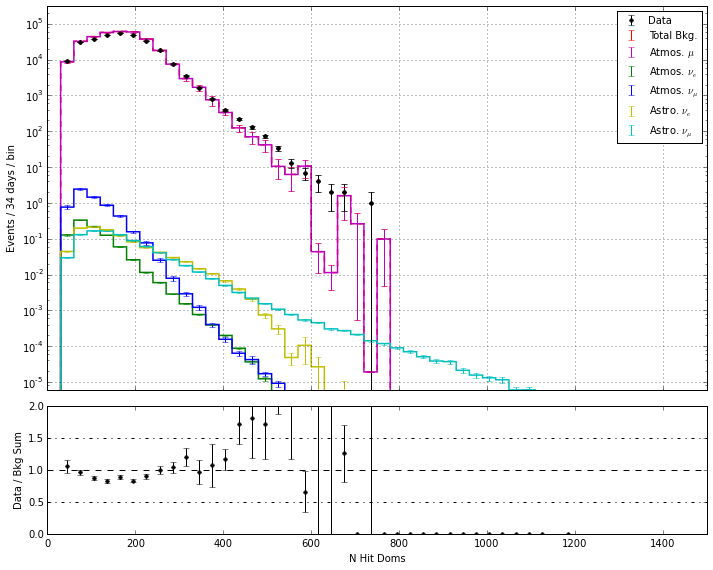

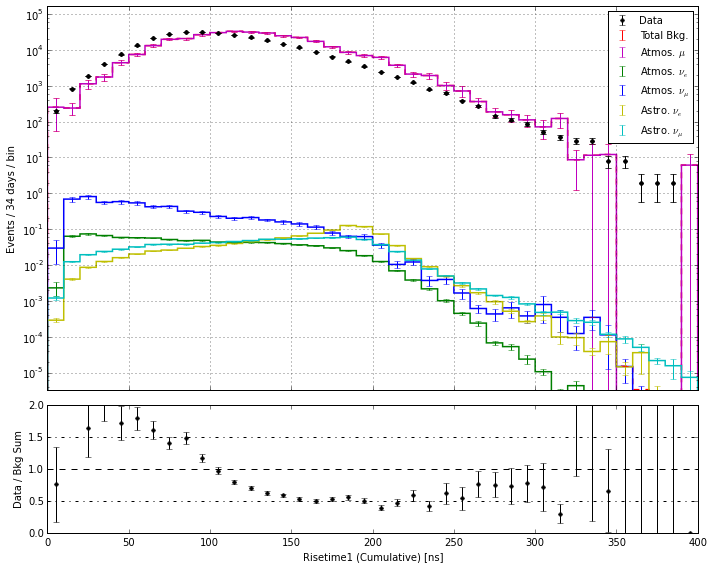

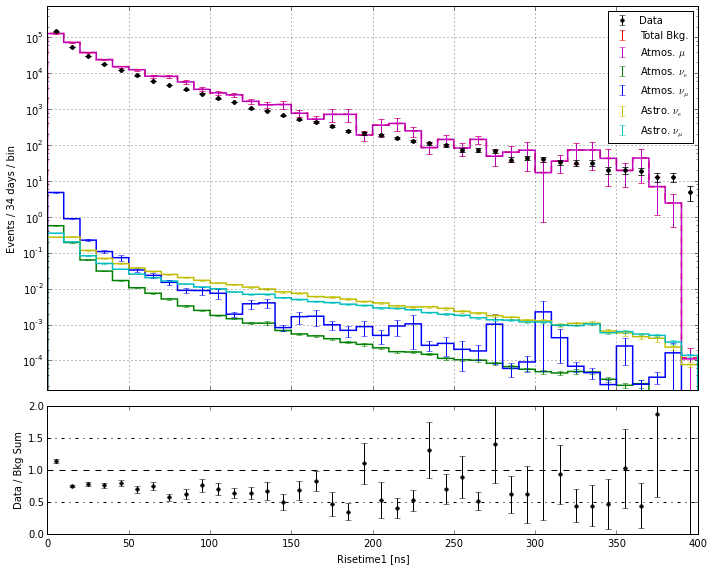

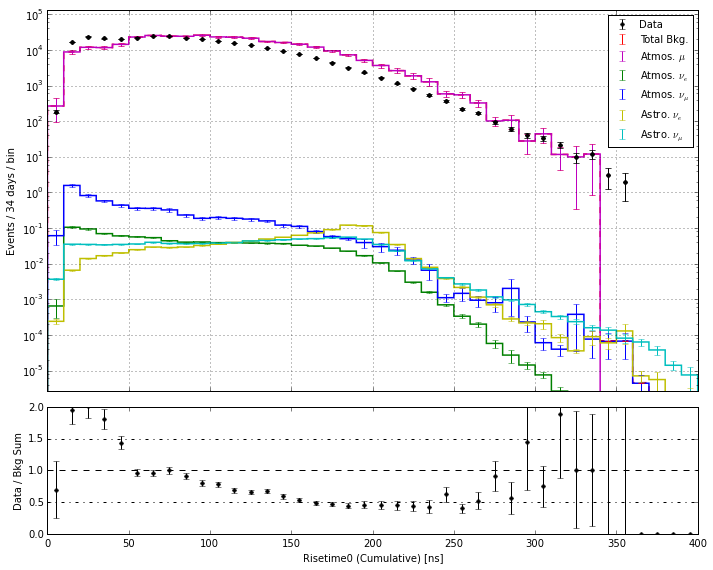

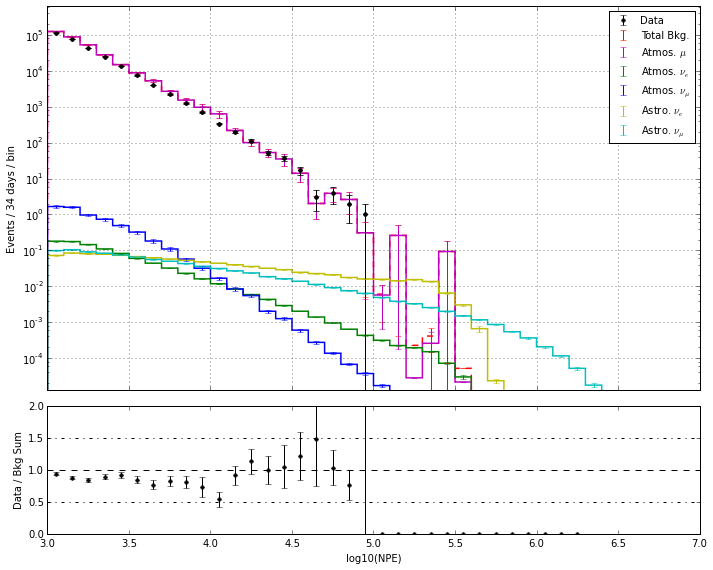

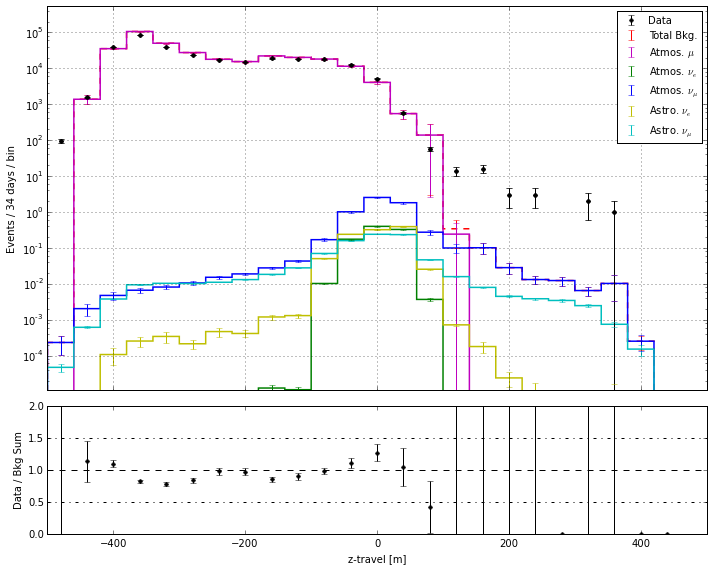

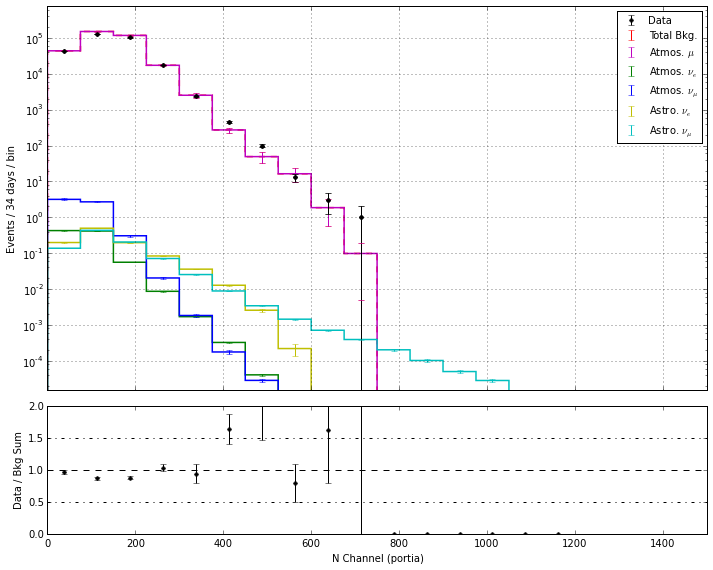

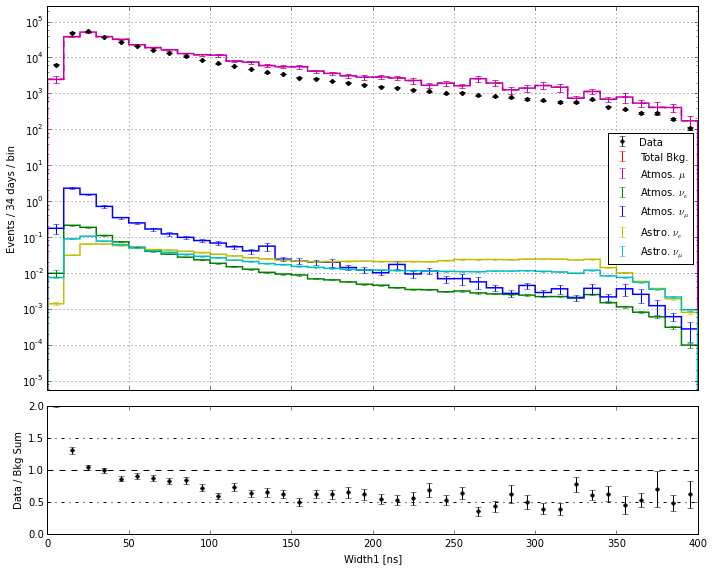

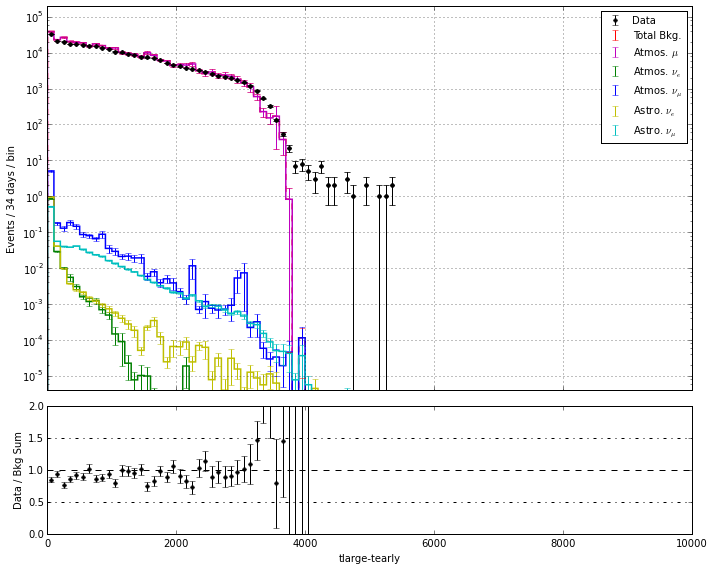

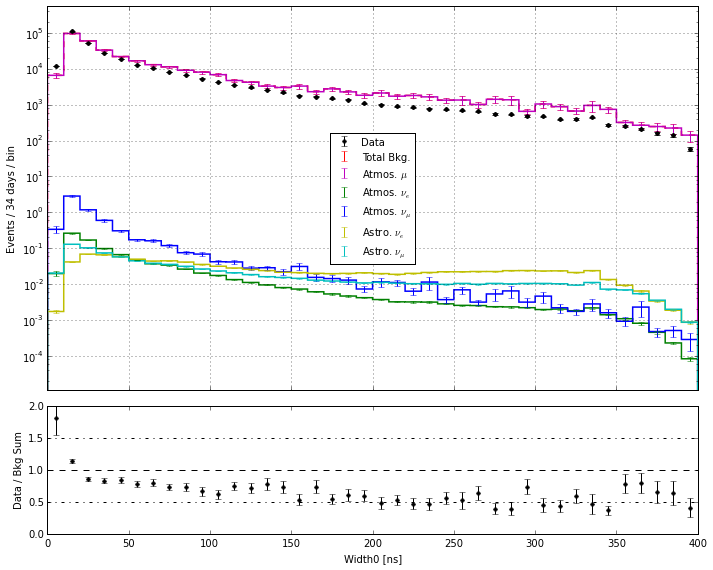

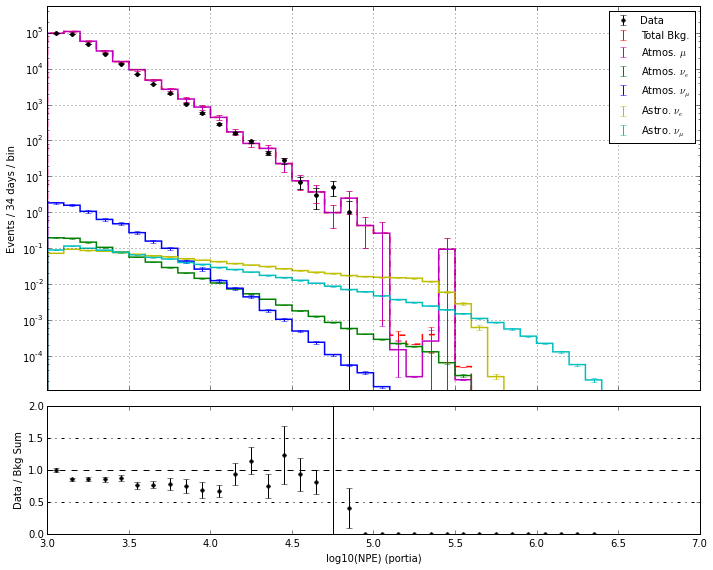

In [13]:
# Remake the plots
for var in variables:
    
    lims = variables[var]
    
    p_tool.plotStackedRatio(info, 
                            var, 
                            lims[4],
                            lims[0], lims[1], lims[2], 
                            1e-10,
                            True, False)
    
    plt.savefig(savedir+'qratiocut_outerhit_rhotravel/'+lims[3]+'.png')

In [14]:
# Cut on the z-travel following the OuterCascades notebook where 
# the selection was optimized
def zcut(dt, lowz, highz):
    return dt[ (dt['hs_z_travel'] < highz) & (dt['hs_z_travel'] > lowz)]

# Add the cut and resave info
# Apply qlayerCut
dt_data = zcut(dt_data, -100, 100)
dt_numu = zcut(dt_numu, -100, 100)
dt_nue  = zcut(dt_nue, -100, 100)
dt_cor  = zcut(dt_cor, -100, 100)
dt_mc   = zcut(dt_mc, -100, 100)

info = getinfo(dt_data, dt_mc, dt_cor, dt_nue, dt_numu)

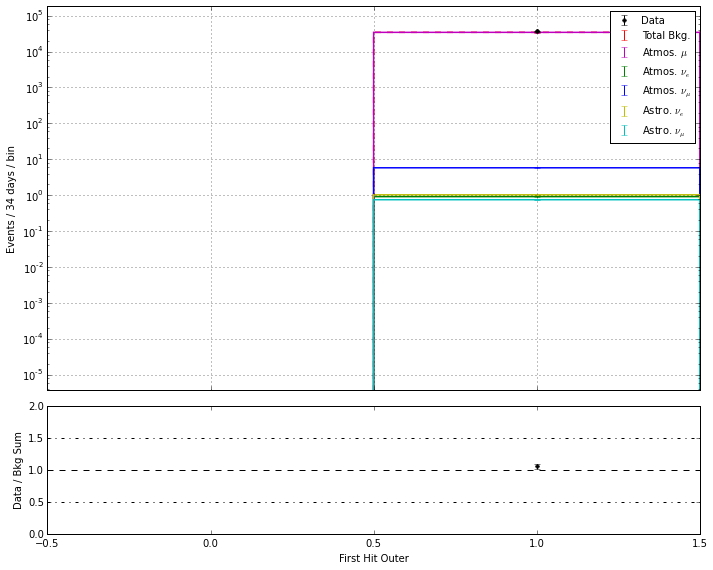

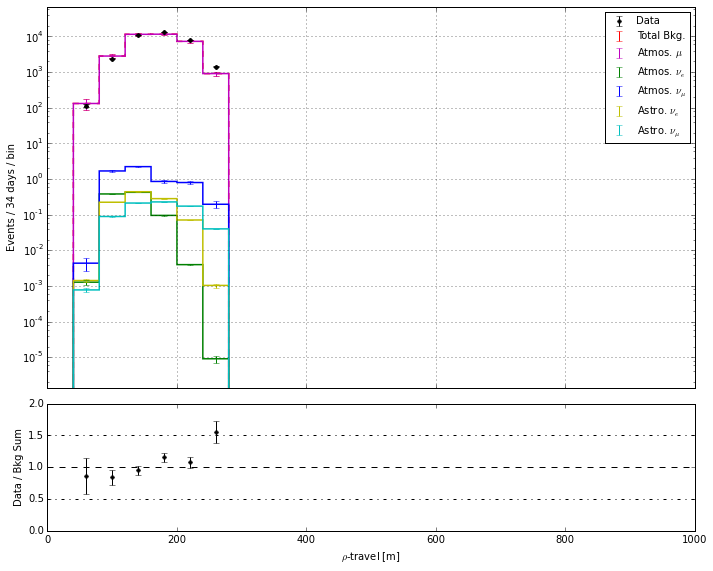

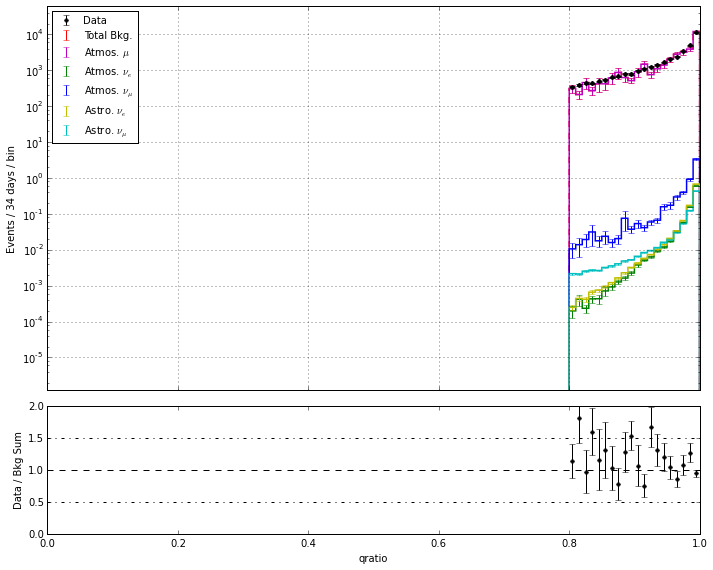

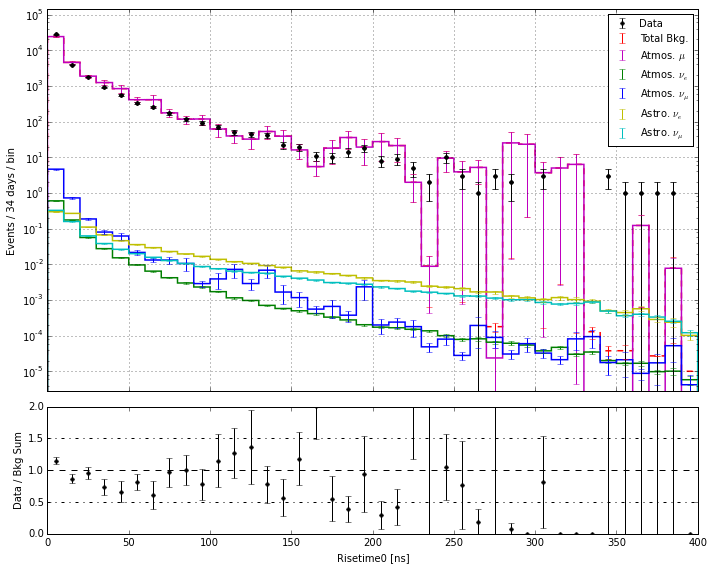

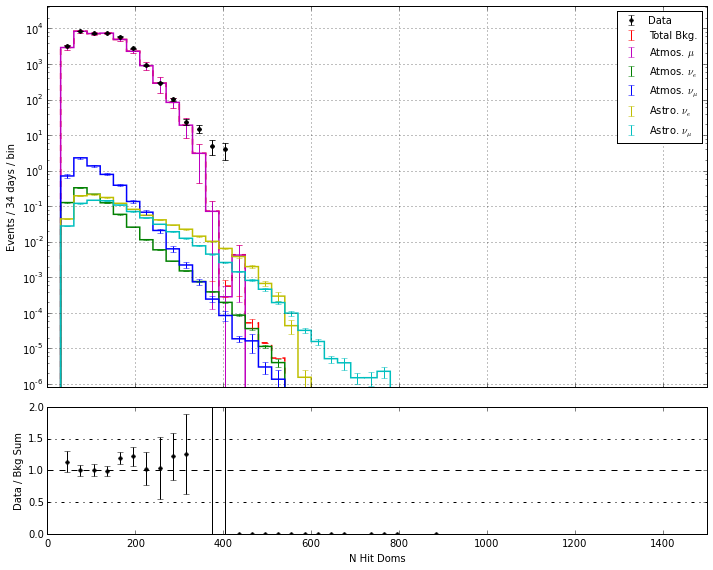

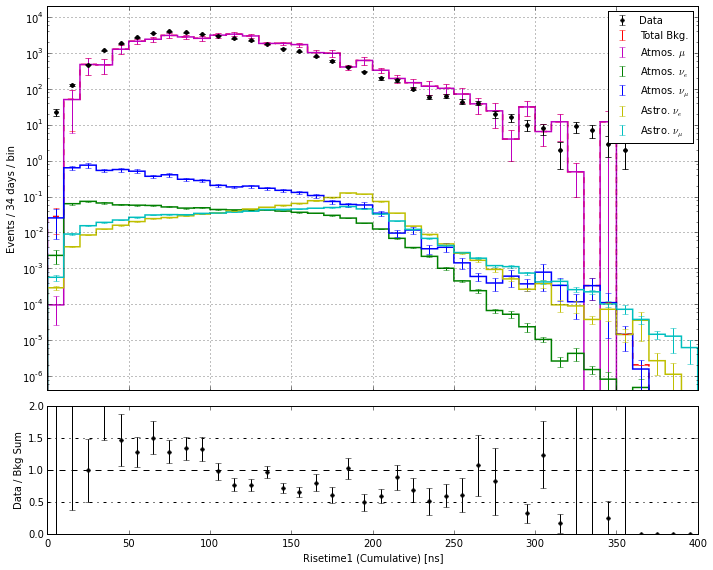

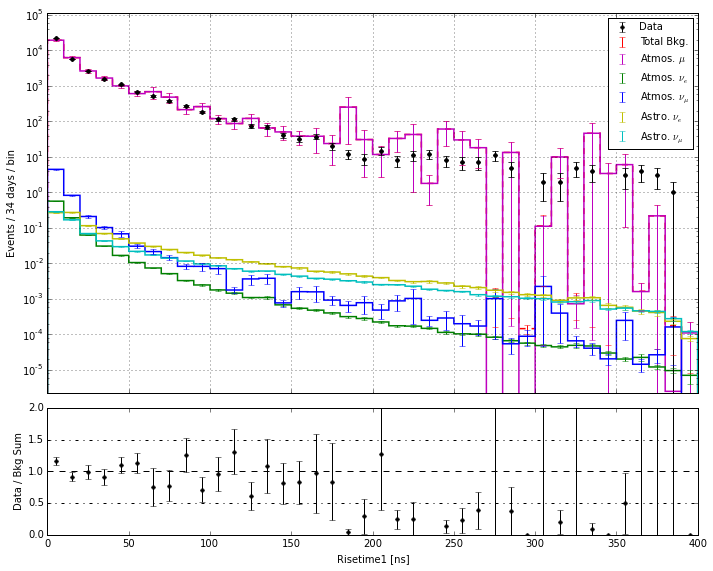

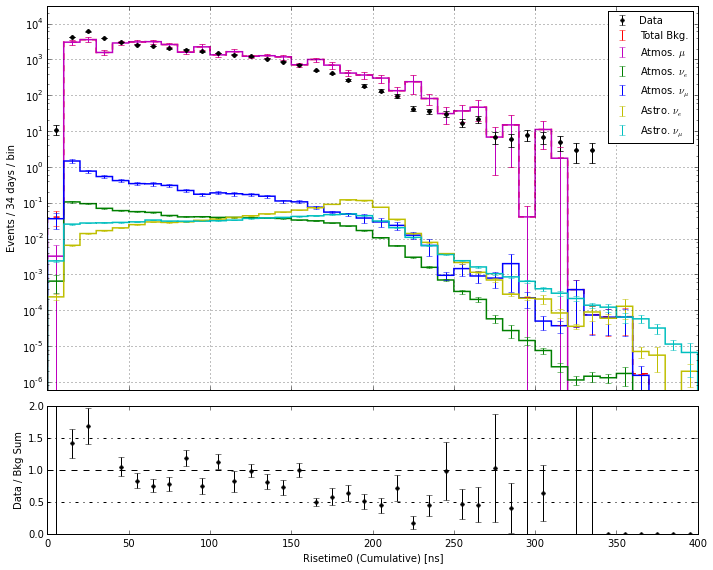

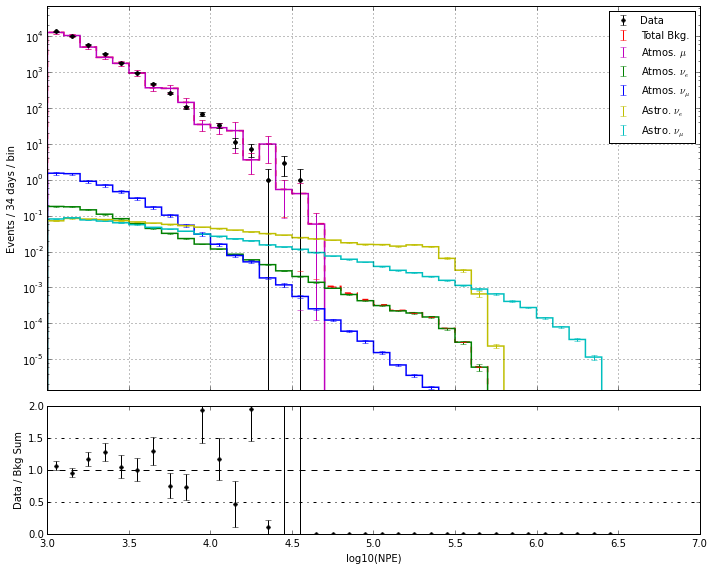

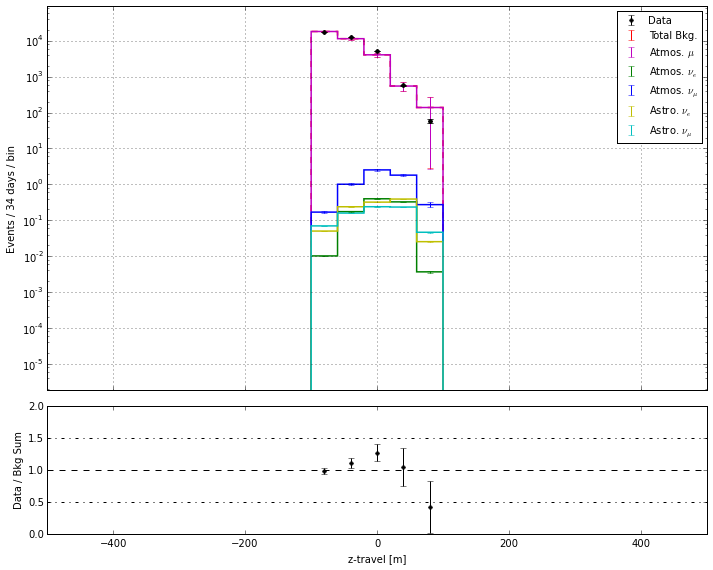

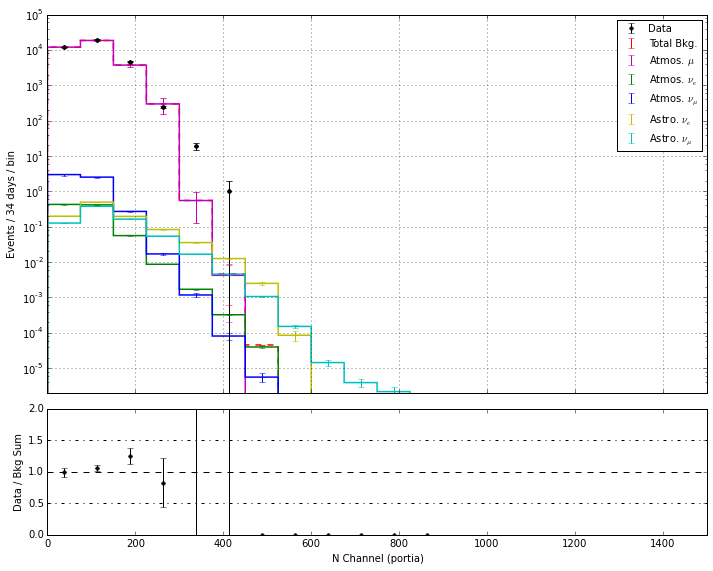

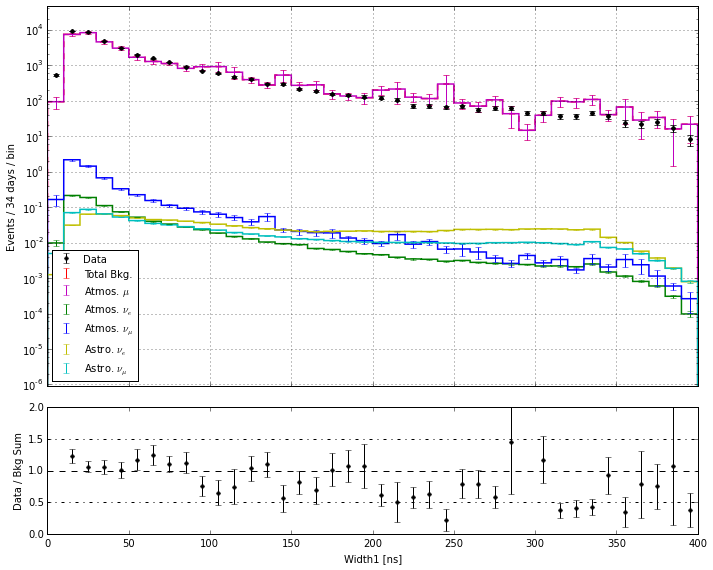

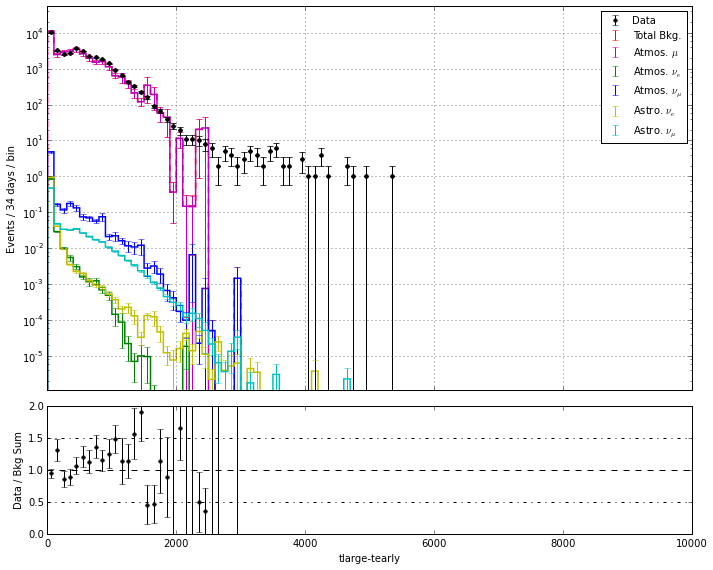

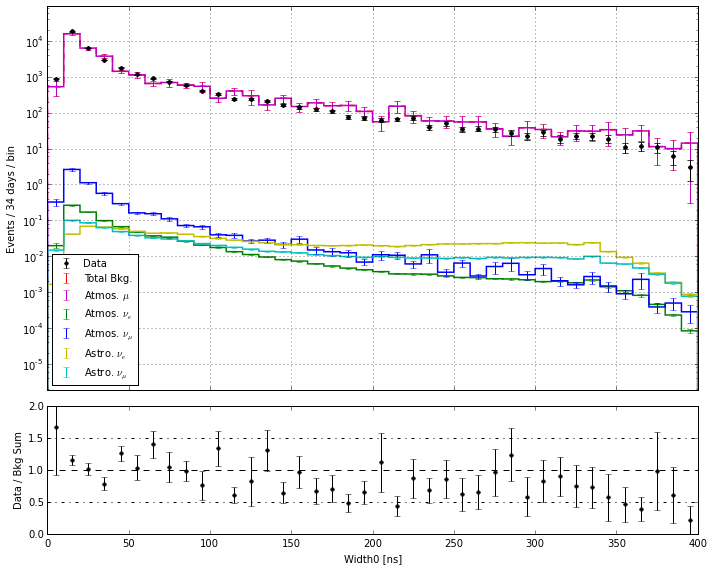

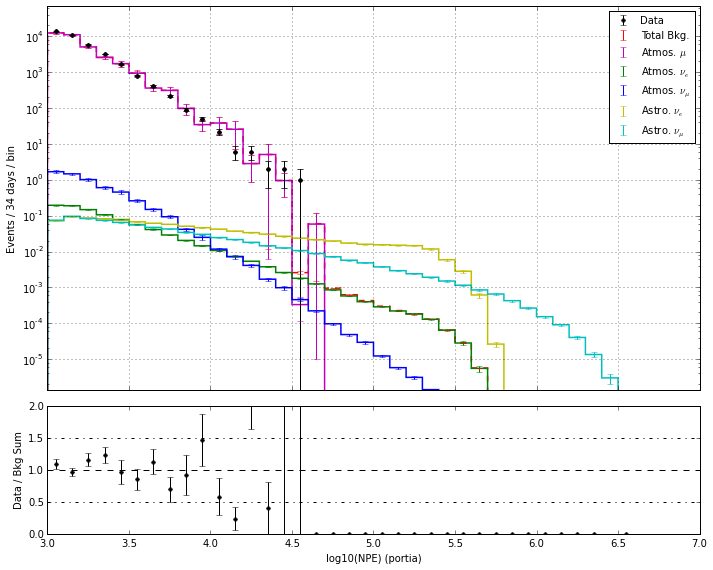

In [16]:
# Remake the plots
for var in variables:
    
    lims = variables[var]
    
    p_tool.plotStackedRatio(info, 
                            var, 
                            lims[4],
                            lims[0], lims[1], lims[2], 
                            1e-10,
                            True, False)
    
    plt.savefig(savedir+'qratiocut_outerhit_rhotravel_ztravel/'+lims[3]+'.png')

In [ ]:
# Let's cut on tlarge-tearly
def dtcut(dt, cval):
    return dt[ dt['tlarge5[0]-tearly5[0]'] < cval]

dt_data = dtcut(dt_data, 200)
dt_numu = dtcut(dt_numu, 200)
dt_nue  = dtcut(dt_nue, 200)
dt_cor  = dtcut(dt_cor, 200)
dt_mc   = dtcut(dt_mc, 200)

info = getinfo(dt_data, dt_mc, dt_cor, dt_nue, dt_numu)

In [45]:
# Quick check

temp = dt_nue[ np.log10(dt_nue['nuE']) >= 6.]
print sum(dt_nue[ dt_nue['log10(hs_q_tot_pulses)'] >= 4.5 ]['wE2']) * 365/34.7
print sum(temp[ temp['log10(hs_q_tot_pulses)'] >= 4.5 ]['wE2']) * 365/34.7

1.61211926755
1.14790968766
